<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/Grok_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q nltk scikit-learn xgboost transformers tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import gc
import os
import pickle
from scipy.sparse import hstack, csr_matrix


In [3]:
# Import NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
# Download required NLTK resources
# Download required NLTK resources with verification
try:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    print("NLTK resources downloaded successfully")

    # Verify downloads worked
    from nltk.tokenize import word_tokenize
    test_tokenize = word_tokenize("Testing NLTK tokenization")
    print("Tokenization test:", test_tokenize)
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

    # Alternative download method
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK resources downloaded successfully
Tokenization test: ['Testing', 'NLTK', 'tokenization']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
print("\n1. Data Loading & Exploration")
# Load the dataset
data = pd.read_csv('fake_job_postings.csv')
print(f"Dataset shape: {data.shape}")

# Check class distribution
print("\nClass distribution:")
print(data['fraudulent'].value_counts())
print(f"Percentage of fraudulent jobs: {data['fraudulent'].mean() * 100:.2f}%")

# Check missing values
print("\nMissing values by column:")
print(data.isnull().sum())


1. Data Loading & Exploration
Dataset shape: (17880, 18)

Class distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64
Percentage of fraudulent jobs: 4.84%

Missing values by column:
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [10]:
# 3. Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Clean text by removing URLs, special characters, and normalizing."""
    if not isinstance(text, str):
        return ''
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase and strip whitespace
    text = text.lower().strip()

    # Simple word-based cleaning instead of using tokenize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Apply text cleaning with progress indicator
print("Cleaning text data...")
# Handle NaN values before processing
data['description'] = data['description'].fillna('')
data['company_profile'] = data['company_profile'].fillna('')

# Process in batches with progress updates
from tqdm.notebook import tqdm
tqdm.pandas()

print("Cleaning job descriptions...")
data['clean_description'] = data['description'].progress_apply(clean_text)
print("Cleaning company profiles...")
data['clean_company_profile'] = data['company_profile'].progress_apply(clean_text)
print("Text cleaning completed")


Cleaning text data...
Cleaning job descriptions...


  0%|          | 0/17880 [00:00<?, ?it/s]

Cleaning company profiles...


  0%|          | 0/17880 [00:00<?, ?it/s]

Text cleaning completed


In [11]:
# 4. Feature Engineering
def profile_completeness(profile):
    """Calculate completeness of company profile."""
    if not isinstance(profile, str) or len(profile.strip()) == 0:
        return 0.0
    return min(1.0, len(profile.split()) / 100.0)  # Normalize by approximate max length

data['profile_completeness'] = data['company_profile'].apply(profile_completeness)

# Industry fraud likelihood (based on training data)
industry_fraud_rate = data.groupby('industry')['fraudulent'].mean().to_dict()
data['industry_fraud_likelihood'] = data['industry'].map(industry_fraud_rate).fillna(0.0)


In [12]:
# 5. Feature Extraction
print("Extracting TF-IDF features...")
# TF-IDF for description and company profile
data['clean_description'] = data['clean_description'].fillna('')
data['clean_company_profile'] = data['clean_company_profile'].fillna('')

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_desc = tfidf_vectorizer.fit_transform(data['clean_description'])
tfidf_profile = tfidf_vectorizer.transform(data['clean_company_profile'])
print(f"TF-IDF features extracted: {tfidf_desc.shape[1]} features")

# Optional: Add BERT embeddings if you have enough compute resources
use_bert = False  # Set to True if you want to use BERT (needs more RAM)

if use_bert:
    print("Generating BERT embeddings (this may take a while)...")
    from transformers import AutoTokenizer, TFAutoModel
    import tensorflow as tf

    # Check for available GPU
    device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
    print(f"Using device: {device}")

    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    model = TFAutoModel.from_pretrained('distilbert-base-uncased')

    def get_bert_embeddings(texts, batch_size=8, max_length=64):
        """Generate DistilBERT embeddings with memory management."""
        embeddings = []
        total_batches = (len(texts) // batch_size) + (1 if len(texts) % batch_size else 0)

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            if i % (10 * batch_size) == 0:
                print(f"Processing batch {i//batch_size + 1}/{total_batches}")

            inputs = tokenizer(batch_texts, return_tensors='tf', max_length=max_length,
                              truncation=True, padding=True)
            outputs = model(inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.append(batch_embeddings)

            # Clean up memory
            tf.keras.backend.clear_session()

        return np.vstack(embeddings)

    # Get DistilBERT embeddings
    bert_embeddings = get_bert_embeddings(data['clean_description'].tolist())
    print(f"BERT embeddings generated with shape: {bert_embeddings.shape}")

    # Convert to sparse matrix to match TF-IDF format
    bert_sparse = csr_matrix(bert_embeddings)

    # Combine all features
    metadata_features = csr_matrix(data[['profile_completeness', 'industry_fraud_likelihood']].values)
    combined_features = hstack([tfidf_desc, tfidf_profile, bert_sparse, metadata_features])
else:
    # Use only TF-IDF features
    metadata_features = csr_matrix(data[['profile_completeness', 'industry_fraud_likelihood']].values)
    combined_features = hstack([tfidf_desc, tfidf_profile, metadata_features])

print(f"Final feature matrix shape: {combined_features.shape}")

Extracting TF-IDF features...
TF-IDF features extracted: 5000 features
Final feature matrix shape: (17880, 10002)


In [14]:
# 6. Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    combined_features, data['fraudulent'],
    test_size=0.2, stratify=data['fraudulent'],
    random_state=42
)

In [15]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 14304 samples
Test set: 3576 samples


In [17]:
# 7. Model Training
# Import necessary modules
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from xgboost import XGBClassifier  # Import XGBClassifier (if not already imported)

print("Training Logistic Regression model...")
# Calculate class weight for imbalanced dataset
pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

# Logistic Regression
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',  # Better for imbalanced data
    C=1.0
)
lr_model.fit(X_train, y_train)

print("Training XGBoost model...")
# XGBoost with fewer features if memory is an issue
xgb_model = XGBClassifier(
    scale_pos_weight=pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5
)
xgb_model.fit(X_train, y_train)

Training Logistic Regression model...
Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:12:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
# 8. Evaluation
from sklearn.metrics import classification_report # Import classification_report

print("\nLogistic Regression Results:")
lr_preds = lr_model.predict(X_test)
print(classification_report(y_test, lr_preds))

print("\nXGBoost Results:")
xgb_preds = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_preds))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3403
           1       0.59      0.92      0.72       173

    accuracy                           0.97      3576
   macro avg       0.79      0.95      0.85      3576
weighted avg       0.98      0.97      0.97      3576


XGBoost Results:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.71      0.84      0.77       173

    accuracy                           0.98      3576
   macro avg       0.85      0.91      0.88      3576
weighted avg       0.98      0.98      0.98      3576




=== PERFORMANCE METRICS ===

Logistic Regression Performance Metrics (%):
Accuracy:  96.56%
Precision: 59.26%
Recall:    92.49%
F1 Score:  72.23%

XGBoost Performance Metrics (%):
Accuracy:  97.60%
Precision: 71.22%
Recall:    84.39%
F1 Score:  77.25%

=== MODEL COMPARISON ===
Accuracy difference: +1.03% (XGBoost better)
Precision difference: +11.96% (XGBoost better)
Recall difference: -8.09% (Logistic Regression better)
F1 difference: +5.01% (XGBoost better)


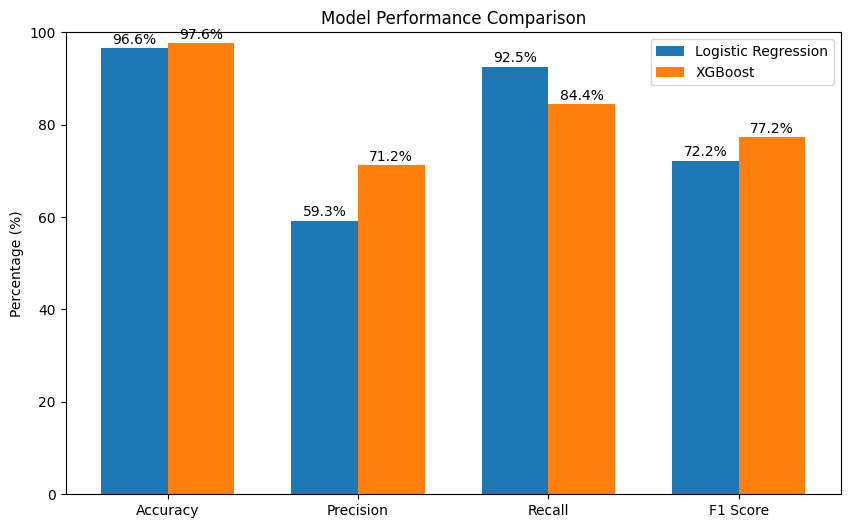

In [20]:
# Add this snippet after your model evaluation section
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to print metrics as percentages
def print_metrics_as_percentage(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100

    print(f"\n{model_name} Performance Metrics (%):")
    print(f"Accuracy:  {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall:    {recall:.2f}%")
    print(f"F1 Score:  {f1:.2f}%")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Calculate metrics for both models
print("\n=== PERFORMANCE METRICS ===")
lr_metrics = print_metrics_as_percentage(y_test, lr_preds, "Logistic Regression")
xgb_metrics = print_metrics_as_percentage(y_test, xgb_preds, "XGBoost")

# Calculate and print improvement percentage between models
print("\n=== MODEL COMPARISON ===")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    diff = xgb_metrics[metric] - lr_metrics[metric]
    print(f"{metric.capitalize()} difference: {diff:+.2f}% ({'XGBoost better' if diff > 0 else 'Logistic Regression better'})")

# Create a simple bar chart of metrics (optional)
try:
    import matplotlib.pyplot as plt

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    lr_values = [lr_metrics['accuracy'], lr_metrics['precision'], lr_metrics['recall'], lr_metrics['f1']]
    xgb_values = [xgb_metrics['accuracy'], xgb_metrics['precision'], xgb_metrics['recall'], xgb_metrics['f1']]

    x = range(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar([i - width/2 for i in x], lr_values, width, label='Logistic Regression')
    ax.bar([i + width/2 for i in x], xgb_values, width, label='XGBoost')

    ax.set_ylabel('Percentage (%)')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 100)
    ax.legend()

    # Add values on top of bars
    for i, v in enumerate(lr_values):
        ax.text(i - width/2, v + 1, f"{v:.1f}%", ha='center')

    for i, v in enumerate(xgb_values):
        ax.text(i + width/2, v + 1, f"{v:.1f}%", ha='center')

    plt.show()
except Exception as e:
    print(f"Couldn't create visualization: {e}")